This code is adapted from OpenAI demo code that you can find [here](https://github.com/openai/openai-cookbook/tree/main/apps/web-crawl-q-and-a).

# Imports

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

import pandas as pd
import numpy as np
import re

import openai
from openai.embeddings_utils import distances_from_embeddings
from openai.embeddings_utils import cosine_similarity

# set here the path to a text file with your OpenAI API key
openai.api_key_path = "../openai"

import tiktoken

# Load and clean texts

### Raw text scrape EAK site

In [32]:
df_a = pd.read_csv("_data/scrape_raw.csv")
df_a = df_a.iloc[:, 1:3]
# df_a.drop_duplicates(inplace=True)
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      166 non-null    object
 1   content  166 non-null    object
dtypes: object(2)
memory usage: 2.7+ KB


### Refined scrape from EAK and AHV/IV site

In [33]:
df_b = pd.read_json("_data/scrape_extended.json")
df_b["content"] = df_b.question + " - " + df_b.answer
df_b = df_b.iloc[:, 2:4]
df_b.columns = ["url", "content"]
# df_b.drop_duplicates(inplace=True)
display(df_b.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      582 non-null    object
 1   content  582 non-null    object
dtypes: object(2)
memory usage: 9.2+ KB


None

In [34]:
def clean_text(text):
    text = re.sub(r'(\n|\r\n|\r|\t)+', ' ', text) 
    return text

In [35]:
df_a.content = df_a.content.apply(clean_text)
df_b.content = df_b.content.apply(clean_text)
df = pd.concat([df_a, df_b])
df.reset_index(inplace=True, drop=True)

# Tokenize

In [37]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")
df['n_tokens'] = df.content.apply(lambda x: len(tokenizer.encode(x)))

In [38]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    
shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['content'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        splits = split_into_many(row[1]['content'])
        splits = [(row[1].url, split) for split in splits]
        shortened.extend(splits)
        
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append((row[1].url, row[1]['content']))

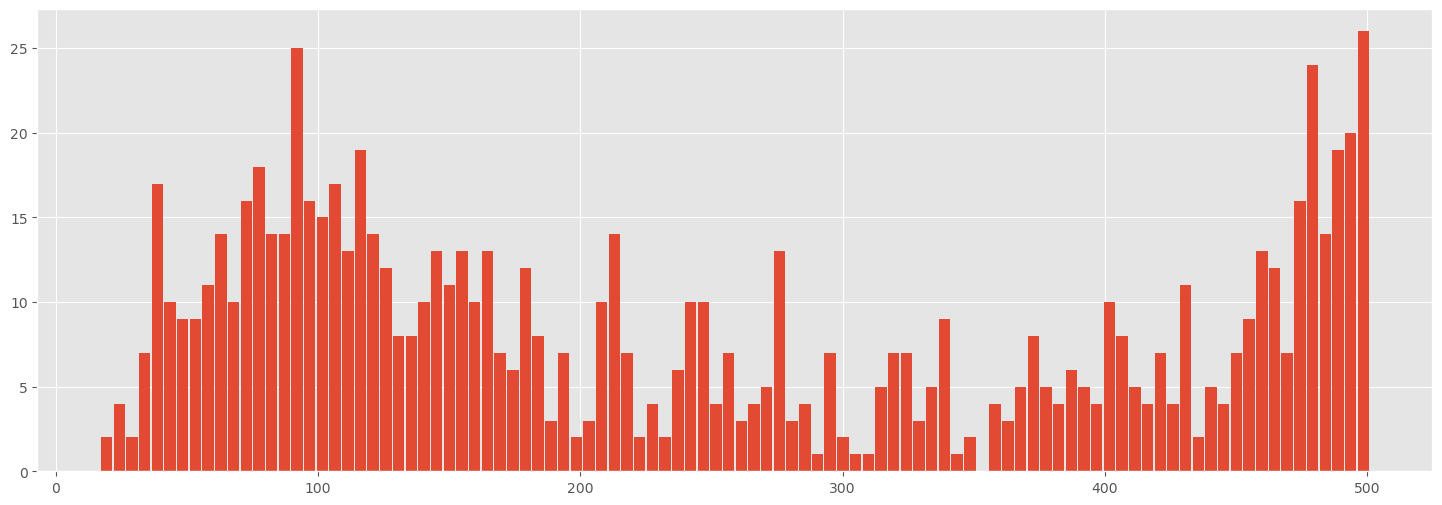

In [55]:
df = pd.DataFrame(shortened, columns = ["url", 'content'])
df['n_tokens'] = df.content.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist(rwidth=.9, bins=100);

# Create embeddings

In [56]:
%%time
df['embeddings'] = df.content.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('../03_app/_data/scrape_embed.csv')
df.head()

CPU times: user 6.75 s, sys: 913 ms, total: 7.67 s
Wall time: 2min 59s


,url,content,n_tokens,embeddings
0,https://www.eak.admin.ch/eak/de/home.html,Reform AHV 21 Vaterschaftse...,448,"[-0.016704805195331573, -0.0005400397931225598..."
1,https://www.eak.admin.ch#context-sidebar,Reform AHV 21 Vaterschaftse...,448,"[-0.016704805195331573, -0.0005400397931225598..."
2,https://www.eak.admin.ch/eak/de/home/Firmen.html,Navigation Themen Anschluss Per...,46,"[0.010128021240234375, -0.002530322875827551, ..."
3,https://www.eak.admin.ch/eak/de/home/Firmen/An...,Navigation ...,159,"[-0.00015793999773450196, -0.00919644348323345..."
4,https://www.eak.admin.ch/eak/de/home/Firmen/An...,Navigation ...,463,"[0.007056905422359705, 0.0013356792042031884, ..."


# Load embeddings

In [62]:
df = pd.read_csv('../03_app/_data/scrape_embed.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

# Inference

In [58]:
def create_context(question, df, max_len=1800, size="ada"):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    reference_links = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["content"])
        reference_links.append(row["url"])
        
    # Return the context and links, from which the information stems
    return "\n\n###\n\n".join(returns), reference_links

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context, links = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, \n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip(), links
    except Exception as e:
        print(e)
        return ""

# Validating the embeddings and model

In [59]:
tests = pd.read_csv("_data/testfragen.csv", header=None, delimiter=";")
tests.columns = ["question", "answer"]
tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  30 non-null     object
 1   answer    30 non-null     object
dtypes: object(2)
memory usage: 608.0+ bytes


In [61]:
for _, data in tests.iterrows():
    print(f"Testfrage: {data.question}")
    print(f"Richtige Antwort: {data.answer}")
    print()
    answer_oai, _ = answer_question(df, question=data.question, max_tokens=500)
    print(f"Antwort GPT: {answer_oai}")
    print()
    print("-"*80)

Testfrage: Wer ist aktuell die Kassenleiterin der EAK? 
Richtige Antwort:  Andrea Steiner

Antwort GPT: Andrea Steiner ist die Kassenleiterin der EAK.

--------------------------------------------------------------------------------
Testfrage: Wer ist der Chef der Leistungen? 
Richtige Antwort:  Carlo Natale

Antwort GPT: Carlo Natale ist der Leiter der Sektion Leistungen.

--------------------------------------------------------------------------------
Testfrage: Wie ist die Telefonnummer der EAK? 
Richtige Antwort:  +41 58 462 64 25

Antwort GPT: 058 462 64 25

--------------------------------------------------------------------------------
Testfrage: Wann wird meine Altersrente im Juni 2023 ausbezahlt? 
Richtige Antwort:  07.06.2023

Antwort GPT: Die Altersrente wird im Juni 2023 am 7. Juni 2023 ausbezahlt.

--------------------------------------------------------------------------------
Testfrage: Wann tritt die neue AHV-Reform in Kraft? 
Richtige Antwort:  1.1.2024

Antwort GPT: D